# Importing Libraries

In [ ]:
!pip install transformers
!pip install datasets
!pip install torchmetrics
!pip install optuna
!pip install -U "neptune[optuna]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.5/481.5 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 97.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel,AutoTokenizer,AdamW
from datasets import load_dataset
from tqdm.auto import tqdm
import numpy as np
import random
from torchmetrics.classification import BinaryAccuracy,MulticlassF1Score,MulticlassPrecision,MulticlassRecall,MulticlassAccuracy,BinaryConfusionMatrix
from torchmetrics.collections import MetricCollection
import optuna
from google.colab import userdata
import neptune
import uuid
import neptune.integrations.optuna as npt_utils
import  hashlib
import time
import math
import pickle
import matplotlib.pyplot as plt

# Setting up the GPU or CPU

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["NEPTUNE_API_TOKEN"] = userdata.get('NEPTUNE_API_TOKEN')
device = torch.device("cuda:0"  if torch.cuda.is_available() else "cpu")

# Define Variable Values

In [ ]:
# @title Define Transformer Model Name
bert_model_name = "bert-base-cased" # @param {type:"string"}

In [ ]:
# @title Define Hugging Face Dataset Name
dataset_name = "krishan-CSE/HatEval-Relabeled" # @param {type:"string"}

In [ ]:
#@title Define Transformer Model Tokenizer Max Padding Length
SEED = 1234
PADDING_MAX_LENGTH = 45 # @param {type:"integer"}

#Configuring Neptuna

In [ ]:
# @title Define Neptuna Project Name,Study ID and Best Trial ID
study_id = "FIN-2958" # @param {type:"string"}
trial_id = "FIN-3021" # @param {type:"string"}
project_name='krishanchavinda.official/Fine-Tuning-DCL-Framework'# @param {type:"string"}

##Load the Study Run

In [ ]:
run_study = neptune.init_run(with_id=study_id,project=project_name)

<ipython-input-8-d2afc0b94731>:1: NeptuneWarning: The following monitoring options are disabled by default in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', and 'capture_hardware_metrics'. To enable them, set each parameter to 'True' when initializing the run. The monitoring will continue until you call run.stop() or the kernel stops. Also note: Your source files can only be tracked if you pass the path(s) to the 'source_code' argument. For help, see the Neptune docs: https://docs.neptune.ai/logging/source_code/
  run_study = neptune.init_run(with_id=study_id,project=project_name)


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-2958


## Load the Best Trial Run

In [ ]:
run_trial = neptune.init_run(with_id=trial_id,project=project_name,mode='read-only')

https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3021


In [ ]:
best_prams=run_trial["parameters"].fetch()

In [ ]:
best_prams

{'ALPHA': 0.3,
 'BATCH_SIZE': 187,
 'DROPOUT': 0.5,
 'EPOCHS': 2,
 'GAMMA': 2,
 'LAMBDA': 0.6481359429549708,
 'LEARNING_RATE': 0.00017187692560983187,
 'SEED': 1234,
 'TEMP_1': 0.1,
 'TEMP_2': 0.05}

# Setting Random Seed for Reproducibility

In [ ]:
def setup_seed(seed:int):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True


In [ ]:
setup_seed(SEED)

# Loading Train,Dev & Test Dataset

In [ ]:
dataset = load_dataset(dataset_name)

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 9088
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 1168
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 2724
    })
})

# Loading the Tokernizer for the Transformer Model

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(bert_model_name)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

##Define the Tokenizer Function

In [ ]:
def tokenize_function(examples):
    return tokenizer.batch_encode_plus(examples["text"], padding='max_length',max_length=PADDING_MAX_LENGTH,add_special_tokens=True,truncation=True)

## Tokenize the Dataset

In [ ]:
tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/9088 [00:00<?, ? examples/s]

Map:   0%|          | 0/1168 [00:00<?, ? examples/s]

Map:   0%|          | 0/2724 [00:00<?, ? examples/s]

## Remove Unwanted Coloumns

In [ ]:
tokenized_datasets=tokenized_datasets.remove_columns(['text'])

## Format the coloumns

In [ ]:
tokenized_datasets=tokenized_datasets.with_format("torch")

In [ ]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9088
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1168
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2724
    })
})

# Creating DataLoaders for Train,Dev & Test Datasets

In [ ]:
train_dataloader=DataLoader(tokenized_datasets["train"], batch_size=best_prams["BATCH_SIZE"] , shuffle=False)

In [ ]:
dev_dataloader=DataLoader(tokenized_datasets["validation"], batch_size=best_prams["BATCH_SIZE"] , shuffle=False)

In [ ]:
test_dataloader=DataLoader(tokenized_datasets["test"], batch_size=best_prams["BATCH_SIZE"] , shuffle=False)

# Define the Dual Contrastive Learning Architecture

In [ ]:
class DCLArchitecture(nn.Module):
    def __init__(self,dropout:float,bert_model_name:str='bert-base-cased'):
        super(DCLArchitecture, self).__init__()
        self.bert = AutoModel.from_pretrained(bert_model_name)
        self.dim = 768
        self.dense = nn.Linear(self.dim, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self,batch_tokenized, if_train=False):
        input_ids = batch_tokenized['input_ids']
        attention_mask = batch_tokenized['attention_mask']
        bert_output = self.bert(input_ids, attention_mask=attention_mask, output_hidden_states=True)
        bert_cls_hidden_state = bert_output[1]
        torch.cuda.empty_cache()

        if if_train:
            bert_cls_hidden_state_aug = self.dropout(bert_cls_hidden_state)
            bert_cls_hidden_state = torch.cat((bert_cls_hidden_state, bert_cls_hidden_state_aug), dim=1).reshape(-1, self.dim)
        else:
            bert_cls_hidden_state = self.dropout(bert_cls_hidden_state)

        linear_output = self.dense(bert_cls_hidden_state)
        linear_output = linear_output.squeeze(1)

        return bert_cls_hidden_state, linear_output

## Define Focal Loss

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha:float=0.4, gamma:float=2, size_average:bool=True):
        super(FocalLoss, self).__init__()
        self.alpha = torch.tensor(alpha)
        self.gamma = gamma
        self.size_average = size_average

    def forward(self, pred, target):

        device = target.device
        self.alpha = self.alpha.to(device)

        pred = nn.Sigmoid()(pred)
        pred = pred.view(-1, 1)
        target = target.view(-1, 1)
        pred = torch.cat((1-pred, pred), dim=1)

        class_mask = torch.zeros(pred.shape[0], pred.shape[1]).to(device)
        class_mask.scatter_(1, target.view(-1, 1).long(), 1.)
        probs = (pred * class_mask).sum(dim=1).view(-1, 1)
        probs = probs.clamp(min=0.0001, max=1.0)

        log_p = probs.log()
        alpha = torch.ones(pred.shape[0], pred.shape[1]).to(device)
        alpha[:, 0] = alpha[:, 0] * (1 - self.alpha)
        alpha[:, 1] = alpha[:, 1] * self.alpha
        alpha = (alpha * class_mask).sum(dim=1).view(-1, 1)

        batch_loss = -alpha * (torch.pow((1 - probs), self.gamma)) * log_p

        if self.size_average:
            loss = batch_loss.mean()
        else:
            loss = batch_loss.sum()

        return loss

## Define Unsupervised Contrastive loss

In [ ]:
def simcse_loss(batch_emb,temp_1:float):
    batch_size = batch_emb.size(0)
    y_true = torch.cat([torch.arange(1, batch_size, step=2, dtype=torch.long).unsqueeze(1),
                        torch.arange(0, batch_size, step=2, dtype=torch.long).unsqueeze(1)],
                       dim=1).reshape([batch_size,]).to(device)
    norm_emb = F.normalize(batch_emb, dim=1, p=2)
    sim_score = torch.matmul(norm_emb, norm_emb.transpose(0,1))
    sim_score = sim_score - (torch.eye(batch_size) * 1e12).to(device)
    sim_score = sim_score / temp_1
    loss_func = nn.CrossEntropyLoss()
    loss = loss_func(sim_score, y_true)

    return loss


## Define Supervised Contrastive loss

In [ ]:
def sup_simcse_loss(batch_emb, label,temp_2:float):
    n = batch_emb.size(0)

    similarity_matrix = F.cosine_similarity(batch_emb.unsqueeze(1), batch_emb.unsqueeze(0), dim=2)
    mask = torch.ones_like(similarity_matrix) * (label.expand(n, n).eq(label.expand(n, n).t()))

    mask_no_sim = torch.ones_like(mask) - mask
    mask_dui_jiao_0 = ((torch.ones(n,n) - torch.eye(n,n)) * 1e12).to(device)
    similarity_matrix = torch.exp(similarity_matrix/temp_2)
    similarity_matrix = similarity_matrix * mask_dui_jiao_0

    sim = mask*similarity_matrix
    no_sim = similarity_matrix - sim
    no_sim_sum = torch.sum(no_sim , dim=1)
    no_sim_sum_expend = no_sim_sum.repeat(n, 1).T

    sim_sum  = sim + no_sim_sum_expend
    loss = torch.div(sim , sim_sum)
    loss = mask_no_sim + loss + (torch.eye(n, n)/1e12).to(device)
    loss = -torch.log(loss)
    loss = torch.sum(torch.sum(loss, dim=1))/(2*n)
    return loss

#Configuring the Model & Focal Loss

In [ ]:
model = DCLArchitecture(bert_model_name=bert_model_name,dropout=best_prams["DROPOUT"])
model.to(device)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

DCLArchitecture(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(),lr = best_prams["LEARNING_RATE"])

In [ ]:
criteon = FocalLoss(best_prams["ALPHA"],best_prams["GAMMA"])

#Training the Model

## Format the Labels

In [ ]:
def copy_label(labels):
    labels = labels.unsqueeze(1)
    labels = torch.cat((labels, labels), dim=1).reshape(-1, 1).squeeze(1)
    return labels

## Define Training Loop

In [ ]:
def training_loop(model, train_dataloader,optimizer,criteon,device,temp_1:float,temp_2:float,lamda:float):
    accuracy_metric = BinaryAccuracy()
    accuracy_metric.to(device)
    progress_bar = tqdm(range(len(train_dataloader)))
    model.train()
    total_train_loss = 0.0
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        labels = copy_label(batch["labels"])
        emb, pred = model(batch, if_train=True)
        loss = criteon(pred, labels.float())
        loss_sim = simcse_loss(emb,temp_1=temp_1)
        loss_supsim = sup_simcse_loss(emb, labels,temp_2=temp_2)
        total_train_loss += loss.item()
        loss_value=loss.item()
        pred_sig = torch.sigmoid(pred)
        preds_detach=torch.round(pred_sig.detach())
        accuracy_metric(preds_detach,labels)
        loss = loss + lamda*(loss_sim + loss_supsim)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        progress_bar.update(1)

    average_epoch_train_loss = total_train_loss / len(train_dataloader)  # Compute average epoch loss
    train_accuracy =  accuracy_metric.compute()
    accuracy_metric.reset()
    return average_epoch_train_loss,train_accuracy.item()

## Define Validation Loop

In [ ]:
def validation_loop(model, dev_dataloader,criteon, device,average='macro'):
    collection_metric = MetricCollection(
          BinaryAccuracy(),
          MulticlassPrecision(num_classes=2,average=average),
          MulticlassRecall(num_classes=2,average=average),
          MulticlassF1Score(num_classes=2,average=average),
          BinaryConfusionMatrix()
    )
    collection_metric.to(device)
    model.eval()
    total_dev_loss = 0.0
    for batch in dev_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        labels = batch["labels"]

        with torch.no_grad():
            emb, pred = model(batch , False)
            loss = criteon(pred, labels.float())
            pred_sig = torch.round(torch.sigmoid(pred))
        nan_exist = torch.isnan(pred_sig).any().item()
        if nan_exist:
          collection_metric.reset()
          return None
        total_dev_loss += loss.item()
        collection_metric.update(pred_sig,labels)

    average_epoch_dev_loss = total_dev_loss / len(dev_dataloader)  # Compute average epoch loss
    result = collection_metric.compute()
    result["Loss"]=average_epoch_dev_loss
    result["BinaryConfusionMatrix"],_=collection_metric.BinaryConfusionMatrix.plot()
    collection_metric.reset()
    return result

##Training

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 1.0m 1.99s
	Train Loss: 0.089 | Train Acc: 52.94%
	 Val Loss: 0.060 |  Val Acc: 64.04%
	 Val Macro Precision: 76.812%
	 Val Macro Recall: 61.908%
	 Val Macro F1Score: 57.094%


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 1.0m 4.12s
	Train Loss: 0.061 | Train Acc: 71.52%
	 Val Loss: 0.059 |  Val Acc: 76.71%
	 Val Macro Precision: 76.773%
	 Val Macro Recall: 76.433%
	 Val Macro F1Score: 76.512%


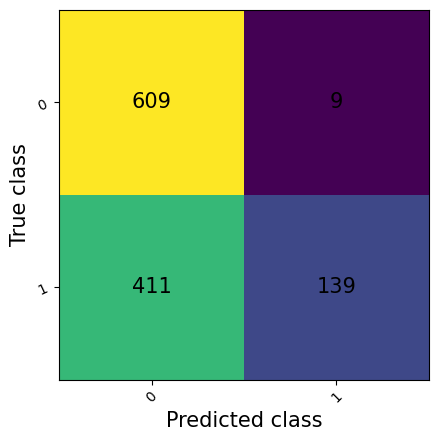

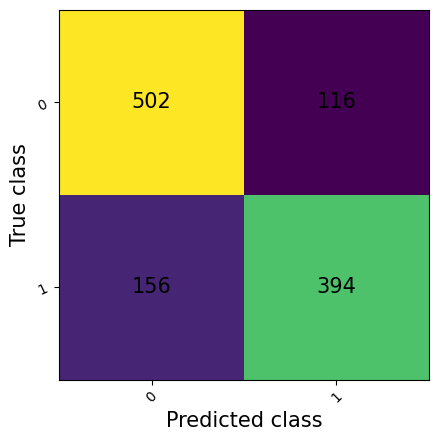

In [ ]:
for epoch in range(best_prams["EPOCHS"]):
        start_time = time.time()
        average_epoch_train_loss,train_accuracy = training_loop(model, train_dataloader,optimizer,criteon,device,best_prams["TEMP_1"],best_prams["TEMP_2"],best_prams["LAMBDA"])
        result_metric = validation_loop(model, dev_dataloader,criteon, device)
        if result_metric!=None:
          dev_loss=result_metric["Loss"]
          dev_accuracy=result_metric["BinaryAccuracy"].item()
          dev_precision=result_metric['MulticlassPrecision'].item()
          dev_recall=result_metric['MulticlassRecall'].item()
          dev_f1score=result_metric['MulticlassF1Score'].item()
          end_time = time.time()

          epoch_mins, epoch_secs = divmod(end_time - start_time, 60)
          print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs:.2f}s')
          print(f'\tTrain Loss: {average_epoch_train_loss:.3f} | Train Acc: {train_accuracy*100:.2f}%')
          print(f'\t Val Loss: {dev_loss:.3f} |  Val Acc: {dev_accuracy*100:.2f}%')
          print(f'\t Val Macro Precision: {dev_precision*100:.3f}%')
          print(f'\t Val Macro Recall: {dev_recall*100:.3f}%')
          print(f'\t Val Macro F1Score: {dev_f1score*100:.3f}%')


# Evaluate with Test Dataset

In [ ]:
def test_loop(model, test_dataloader,criteon, device,average:str="macro"):
    collection_metric = MetricCollection(
          BinaryAccuracy(),
          MulticlassPrecision(num_classes=2,average=average),
          MulticlassRecall(num_classes=2,average=average),
          MulticlassF1Score(num_classes=2,average=average),
          BinaryConfusionMatrix()
    )
    collection_metric.to(device)
    model.eval()
    total_test_loss = 0.0
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        labels = batch["labels"]
        with torch.no_grad():
            emb, pred = model(batch , False)
            loss = criteon(pred, labels.float())
            pred = torch.round(torch.sigmoid(pred))
        total_test_loss += loss.item()
        collection_metric.update(pred, labels)

    average_epoch_test_loss = total_test_loss / len(test_dataloader)  # Compute average epoch loss
    result =  collection_metric.compute()
    result['Loss']= average_epoch_test_loss
    result["BinaryConfusionMatrix"],_=collection_metric.BinaryConfusionMatrix.plot()
    collection_metric.reset()
    return result

## Test the model with Test Set

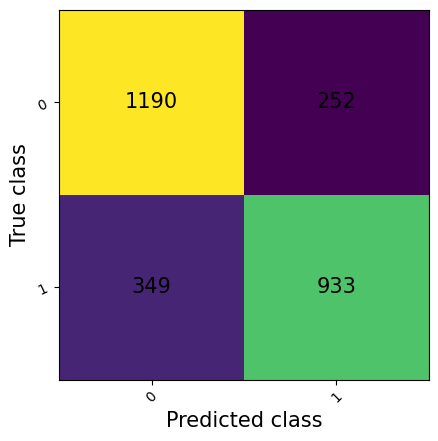

In [ ]:
result_metrics=test_loop(model, test_dataloader,criteon, device)

In [ ]:
result_metrics

{'BinaryAccuracy': tensor(0.7794, device='cuda:0'),
 'MulticlassPrecision': tensor(0.7803, device='cuda:0'),
 'MulticlassRecall': tensor(0.7765, device='cuda:0'),
 'MulticlassF1Score': tensor(0.7774, device='cuda:0'),
 'BinaryConfusionMatrix': <Figure size 640x480 with 1 Axes>,
 'Loss': 0.05759055987000465}

## Upload the Test Results to Neptuna

In [ ]:
def upload_metrics_result(directory:str,result:dict,run: neptune.Run):
    run[f"{directory}/Accuracy"]=result["BinaryAccuracy"].item()
    run[f"{directory}/Focal_Loss"]=result["Loss"]
    run[f"{directory}/Macro_Precision"]=result["MulticlassPrecision"].item()
    run[f"{directory}/Macro_Recall"]=result["MulticlassRecall"].item()
    run[f"{directory}/Macro_F1Score"]=result["MulticlassF1Score"].item()
    run[f"{directory}/ConfusionMatrix"].upload(result["BinaryConfusionMatrix"])
    run.wait()
    plt.close()


In [ ]:
upload_metrics_result(run=run_study ,directory="Test_Results",result=result_metrics)

Upload Successful


# Save the Model Checkpoint

In [ ]:
def save_model_states(model,criteon,optimizer):
    torch.save(model.state_dict(),'model.pt')
    torch.save(criteon.state_dict(),'criteon.pt')
    torch.save(optimizer.state_dict(),'optimizer.pt')

In [ ]:
def upload_model_checkpoint(directory:str,run: neptune.Run):
    run[f"{directory}/model"].upload('model.pt')
    run[f"{directory}/criteon"].upload('criteon.pt')
    run[f"{directory}/optimizer"].upload('optimizer.pt')
    run.wait()

In [ ]:
save_model_states(model=model,criteon=criteon,optimizer=optimizer)
upload_model_checkpoint(run=run_study,directory="model_checkpoints")

In [ ]:
run_trial.stop()
run_study.stop()

Shutting down background jobs, please wait a moment...
Done!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3021/metadata
Shutting down background jobs, please wait a moment...
Done!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-2958/metadata
